<a href="https://colab.research.google.com/github/megha-puthukudi/main-project/blob/main/spot_plot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Found 840 images belonging to 3 classes.
Found 185 images belonging to 3 classes.
Found 180 images belonging to 3 classes.
58889256/58889256 [==============================] - 0s 0us/step
Epoch 1/200
105/105 [==============================] - 320s 3s/step - loss: 4.4009 - accuracy: 0.3286 - val_loss: 3.6698 - val_accuracy: 0.2989
Epoch 2/200
105/105 [==============================] - 17s 158ms/step - loss: 3.2612 - accuracy: 0.3095 - val_loss: 3.2241 - val_accuracy: 0.3261
Epoch 3/200
105/105 [==============================] - 17s 163ms/step - loss: 2.9402 - accuracy: 0.3190 - val_loss: 2.9418 - val_accuracy: 0.3533
Epoch 4/200
105/105 [==============================] - 17s 159ms/step - loss: 2.7524 - accuracy: 0.3488 - val_loss: 2.7131 - val_accuracy: 0.3696
Epoch 5/200
105/105 [==============================] - 17s 161ms/step - loss: 2.6065 - accuracy: 0.3536 - val_loss: 2.4499 - val_accuracy: 0.4185
Epoch 6/200
105/105 [==============================] - 17s 157ms/step - loss: 2.4084

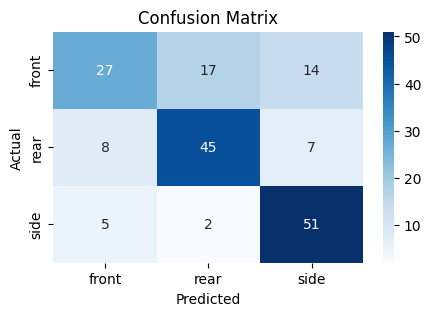

Test loss: 1.1933
Test accuracy: 70.45
Train loss: 0.3980
Train accuracy: 85.12
Recall: 0.70
Precision: 0.70
F1-score: 0.69


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16  # Changed to VGG16
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from sklearn.metrics import recall_score, precision_score, f1_score, confusion_matrix
import seaborn as sns  # Added seaborn for visualization

# Define your data directories
train_dir = '/content/drive/MyDrive/spot/train'
val_dir = '/content/drive/MyDrive/spot/validation'
test_dir = '/content/drive/MyDrive/spot/test'

# Define image size and batch size
img_size = (224, 224)  # VGG16 requires input size to be (224, 224)
batch_size = 8 # Keep batch size as 32

# Create data generators with more aggressive data augmentation
train_datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.vgg16.preprocess_input,  # Update to VGG16 preprocessing
    rotation_range=40,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input)  # Update to VGG16 preprocessing
test_datagen = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input)  # Update to VGG16 preprocessing

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

# Load the pre-trained VGG16 model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))  # Adjusted input shape

# Add a global average pooling layer
x = GlobalAveragePooling2D()(base_model.output)

# Add a dense output layer with softmax activation
predictions = Dense(3, activation='softmax')(x)

# Create the model
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the layers in the base model except the last few
for layer in base_model.layers:
    layer.trainable = False

# Compile the model with a lower learning rate
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model with early stopping
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.n // batch_size,
    epochs=200,
    validation_data=val_generator,
    validation_steps=val_generator.n // batch_size,
)

# Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate(test_generator, steps=test_generator.n // batch_size)
train_loss, train_accuracy = model.evaluate(train_generator, steps=train_generator.n // batch_size)

# Calculate recall
y_true = []
y_pred = []
for i in range(test_generator.n // batch_size):
    batch_x, batch_y = next(test_generator)
    y_true.extend(np.argmax(batch_y, axis=1))
    y_pred.extend(np.argmax(model.predict(batch_x), axis=1))

# Calculate confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Visualize the confusion matrix as a heatmap
plt.figure(figsize=(5, 3))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['front', 'rear', 'side'], yticklabels=['front', 'rear', 'side'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Calculate other metrics
recall = recall_score(y_true, y_pred, average='macro')
precision = precision_score(y_true, y_pred, average='macro')
f1 = f1_score(y_true, y_pred, average='macro')
# Display metrics
print(f'Test loss: {test_loss:.4f}')
print(f'Test accuracy: {test_accuracy * 100:.2f}')
print(f'Train loss: {train_loss:.4f}')
print(f'Train accuracy: {train_accuracy * 100:.2f}')
print(f'Recall: {recall:.2f}')
print(f'Precision: {precision:.2f}')
print(f'F1-score: {f1:.2f}')

# Save the trained model
model.save('/content/drive/MyDrive/colabtest/vecicle_spot_position_VGG16_8batchepoch_200_dataset.h5')


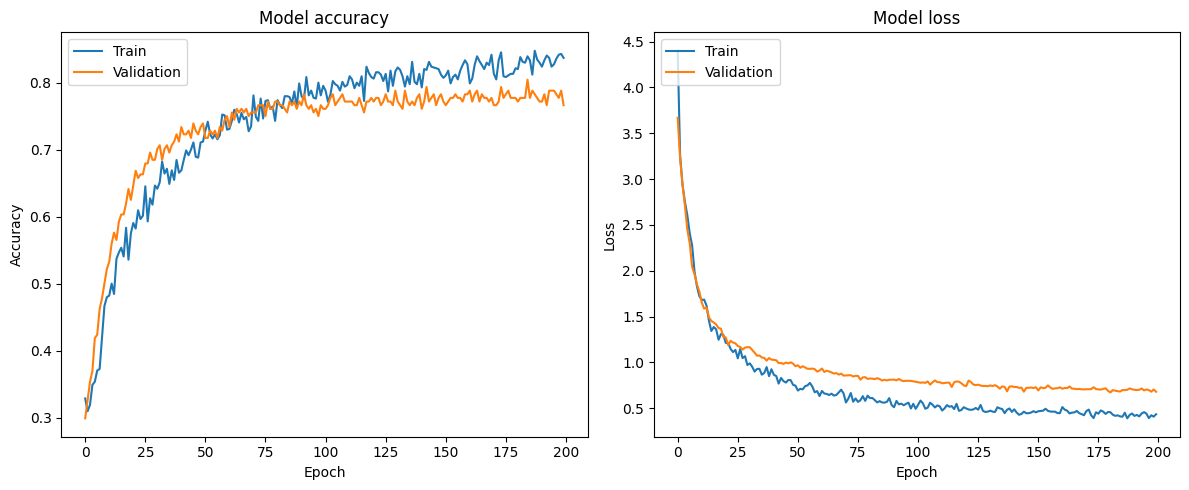

In [2]:
import matplotlib.pyplot as plt

# Plot training history
plt.figure(figsize=(12, 5))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()


In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator# Importing ImageDataGenerator for real-time data augmentation on image data
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, Flatten #Flatten layer is used to flatten the input data from a multi-dimensional shape into one-dimensional array
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from sklearn.metrics import recall_score, precision_score, f1_score, confusion_matrix
import seaborn as sns # Added seaborn for visualization (attractive and informative statistical graphics)

# Define your data directories
train_dir = '/content/drive/MyDrive/damaged dataset - Copy (2)/train'
val_dir = '/content/drive/MyDrive/damaged dataset - Copy (2)/validation'
test_dir = '/content/drive/MyDrive/damaged dataset - Copy (2)/test'

# Define image size and batch size
img_size = (224, 224)
batch_size = 32  # Batch size is the number of samples processed by the model at each iteration during training.

# Create data generators
train_datagen = ImageDataGenerator(
    # This initializes an ImageDataGenerator object named train_datagen responsible for generating augmented images from the original dataset during training.

    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest' # Fill newly created pixels with values from the nearest existing pixel(as it left shift or other).
)

val_datagen = ImageDataGenerator(rescale=1./255)# Rescale pixel values of validation images to [0, 1](for normalization process).
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,# Directory containing training images
    target_size=img_size,# Resize all images to the specified dimensions
    batch_size=batch_size,# Number of images in each batch
    class_mode='categorical'# For multi-class classification, use 'categorical' to get one-hot encoded labels

)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

# Load the pre-trained VGG16 model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Flatten the output of VGG16
x = Flatten()(base_model.output)

# Add a fully connected layer for classification
predictions = Dense(2, activation='softmax')(x)  # Assuming 2 classes: car and damaged car

# Create the model
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the layers in the base model
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.n // batch_size,
    epochs=200,# Number of times the entire training dataset is passed through the model
    validation_data=val_generator,
    validation_steps=val_generator.n // batch_size
)

# Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate(test_generator, steps=test_generator.n // batch_size)
train_loss, train_accuracy = model.evaluate(train_generator, steps=train_generator.n // batch_size)


# Calculate recall

y_true = []# List to store true labels
y_pred = []# List to store predicted labels
for i in range(test_generator.n // batch_size):
      # Retrieve the next batch of input images and their corresponding true labels
    batch_x, batch_y = next(test_generator)
        # Extract true labels from batch_y and append to y_true list
    y_true.extend(np.argmax(batch_y, axis=1))
    # Obtain model predictions for the input images in the current batch
    y_pred.extend(np.argmax(model.predict(batch_x), axis=1))


# Calculate confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Visualize the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not damaged', 'Damaged car'], yticklabels=['Not damaged', 'Damaged car'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Calculate other metrics
recall = recall_score(y_true, y_pred, average='macro')
precision = precision_score(y_true, y_pred, average='macro')
f1 = f1_score(y_true, y_pred, average='macro')

# Display metrics
print(f'Test loss: {test_loss:.4f}')
print(f'Test accuracy: {test_accuracy * 100:.2f}')
print(f'Train loss: {train_loss:.4f}')
print(f'Train accuracy: {train_accuracy * 100:.2f}')
print(f'Recall: {recall:.2f}')
print(f'Precision: {precision:.2f}')
print(f'F1-score: {f1:.2f}')

# Save the trained model
model.save('/content/drive/MyDrive/colabtest/vecicle_damage_VGG16_batch16_newcrash_dataset_epoch_200_changed_new_dataset.h5')
